In [2]:
import sys
import os
import os.path as op

import glob
import numpy as np
import pandas as pd
import datetime
import netCDF4 as netcdf
from datetime import timedelta
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from math import pi
import xarray as xr
from scipy.stats import gaussian_kde

# dev library
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..'))

# dependencies
from lib import wrapSpectra, spectra, sat, plot_sat, model
from lib.config import * 


# Partitions correction: Comparison between MFWAM model and CFOSAT

In [3]:
#ds_data = xr.open_dataset(op.join(p_output, 'ds_dataTracks.nc'))
ds = xr.open_dataset(op.join(p_output, 'energy_BINS.nc'))

In [4]:
# for MFWAM position i -> CFOSAT position 
dataframe = ds[['pos_corr', 'mf_hs0', 'mf_hs1', 'mf_hs2','SWH(m)']].to_dataframe().dropna()

## Scatter-plot Hs differences

In [10]:
cfosat_p1, cfosat_p2, cfosat_p3, mfwam_p1, mfwam_p2, mfwam_p3 = [], [], [], [], [], []
for pfile, file in enumerate(ds.file.values):
    sys.stdout.write('\r File number: {0}\{1}'.format(pfile,len(ds.file.values)))
    sys.stdout.flush()
            
    for posneg in ds.posneg.values:
        for nbox in ds.nbox.values:
            for partition in ds.partition.values:
                
                swim_pos = ds.sel(file=file, posneg=posneg, nbox=nbox, partition=partition).pos_corr.values
                if np.isnan(swim_pos) == False:
                    
                    cfosat = ds.sel(file=file, posneg=posneg, nbox=nbox, partition=int(swim_pos)+1)['SWH(m)'].values
                    
                    if swim_pos == 1:
                        mfwam = ds.sel(file=file, posneg=posneg, nbox=nbox, partition=partition)['mf_hs0'].values
                        mfwam_p1.append(mfwam)
                        cfosat_p1.append(cfosat)
                        
                    elif swim_pos == 2:
                        mfwam = ds.sel(file=file, posneg=posneg, nbox=nbox, partition=partition)['mf_hs1'].values
                        mfwam_p2.append(mfwam)
                        cfosat_p2.append(cfosat)
                                   
                    else:
                        mfwam = ds.sel(file=file, posneg=posneg, nbox=nbox, partition=partition)['mf_hs2'].values
                        mfwam_p3.append(mfwam)
                        cfosat_p3.append(cfosat)


 File number: 96\97

In [24]:
cfosat_p1 = np.concatenate([cfosat_p1])
cfosat_p2 = np.concatenate([cfosat_p2])
cfosat_p3 = np.concatenate([cfosat_p3])

mfwam_p1 = np.concatenate([mfwam_p1])
mfwam_p2 = np.concatenate([mfwam_p2])
mfwam_p3 = np.concatenate([mfwam_p3])

In [5]:
def gauss_kde(x, y):
    'Calculate the point density'
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    return(x, y, z)


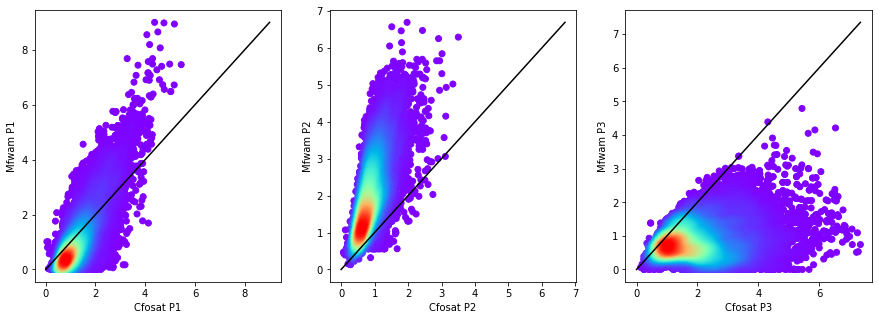

In [26]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

x, y = cfosat_p1, mfwam_p1
x, y, z = gauss_kde(x, y)

axs[0].scatter(x, y, c=z, cmap='rainbow')
axs[0].plot([0, np.nanmax([np.nanmax(cfosat_p1), np.nanmax(mfwam_p1)])], [0, np.nanmax([np.nanmax(cfosat_p1), np.nanmax(mfwam_p1)])], c='k')
axs[0].set_xlabel('Cfosat P1')
axs[0].set_ylabel('Mfwam P1')

x, y = cfosat_p2, mfwam_p2
x, y, z = gauss_kde(x, y)

axs[1].scatter(x, y, c=z, cmap='rainbow')
axs[1].plot([0, np.nanmax([np.nanmax(cfosat_p2), np.nanmax(mfwam_p2)])], [0, np.nanmax([np.nanmax(cfosat_p2), np.nanmax(mfwam_p2)])], c='k')
axs[1].set_xlabel('Cfosat P2')
axs[1].set_ylabel('Mfwam P2')

x, y = cfosat_p3, mfwam_p3
x, y, z = gauss_kde(x, y)

axs[2].scatter(x, y, c=z, cmap='rainbow')
axs[2].plot([0, np.nanmax([np.nanmax(cfosat_p3), np.nanmax(mfwam_p3)])], [0, np.nanmax([np.nanmax(cfosat_p3), np.nanmax(mfwam_p3)])], c='k')
axs[2].set_xlabel('Cfosat P3')
axs[2].set_ylabel('Mfwam P3')
plt.show()

In [6]:
dataframe1 = ds[['pos_corr', 'mf_hs0', 'mf_hs1', 'mf_hs2','SWH(m)']].to_dataframe().reset_index().fillna(0)

Hs_MFWAM = np.sqrt(dataframe1.loc[dataframe1.partition==1]['mf_hs0'].values**2 + dataframe1.loc[dataframe1.partition==1]['mf_hs1'].values**2 + dataframe1.loc[dataframe1.partition==1]['mf_hs2'].values**2)
Hs_CFOSAT = np.sqrt(dataframe1.loc[dataframe1.partition==1]['SWH(m)'].values**2 + dataframe1.loc[dataframe1.partition==2]['SWH(m)'].values**2 + dataframe1.loc[dataframe1.partition==3]['SWH(m)'].values**2)


**Statistical outlier detector - Linear regression - Confidence interval**


In [7]:
# 2. 95% of the area is between -1.96 and 1.96.

1.1878785364782976


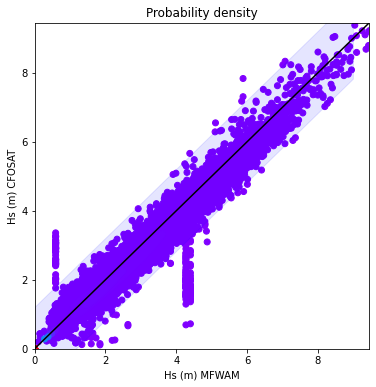

In [18]:
xymax = np.nanmax([np.nanmax(Hs_MFWAM), np.nanmax(Hs_CFOSAT)])
fig = plt.figure(figsize=(6,6))

# axis 0
x, y = Hs_MFWAM, Hs_CFOSAT
x, y, z = gauss_kde(x, y)

#some confidence interval
diff = np.abs(y - x)
#ci = 1.96 * np.std(diff)/np.mean(diff)
ci = 0.5 * np.std(diff)/np.mean(diff)
rect = np.arange(0, xymax, 1)
print(ci)

plt.scatter(x, y, c=z, cmap='rainbow')
plt.plot([0,xymax], [0,xymax], c='k')
plt.fill_between(rect, (rect-ci), (rect+ci), color='b', alpha=.1)

# attrs
plt.xlim([0, xymax])
plt.ylim([0, xymax])
plt.xlabel('Hs (m) MFWAM')
plt.ylabel('Hs (m) CFOSAT')
plt.title('Probability density')

plt.show()